In [1]:
using AbstractGPs
using Distributions
using Flux
using KernelFunctions
using LinearAlgebra
using Plots
using CSV ,DataFrames
using Turing
using FillArrays
using Plots
using ReverseDiff
using StatsBase
using LinearAlgebra
using Random

In [2]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022-1.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix(data0[1:365,[5]])))
    dataset2020=Array(transpose(Matrix(data1[1:365,[4]])))
    x0=Array(transpose(dataset2020[1:364]))
    y0=Array(transpose(dataset2020[2:365]))
    x1=Array(transpose(dataset2021[1:364]))
    y1=Array(transpose(dataset2021[2:365]))
    x2=Array(transpose(dataset2022[1:364]))
    y2=Array(transpose(dataset2022[2:365]))
end

1×364 Matrix{Float64}:
 7.9  10.5  12.4  8.7  2.6  8.4  9.5  …  11.4  12.3  11.9  13.7  11.8  10.5

In [3]:
neuralnet = Chain(Dense(1, 10), Dense(10, 10), Dense(10, 1))

Chain(
  Dense(1 => 10),                       # 20 parameters
  Dense(10 => 10),                      # 110 parameters
  Dense(10 => 1),                       # 11 parameters
)                   # Total: 6 arrays, 141 parameters, 948 bytes.

In [4]:
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1 => 10), Dense(10 => 10), Dense(10 => 1))

In [5]:
p_in, re = Flux.destructure(neuralnet)

(Float32[-0.70309144, 0.39706525, -0.59336776, 0.015806248, -0.28054127, 0.0691194, -0.181024, -0.2501573, -0.24210438, -0.3219966  …  -0.43439335, 0.03308949, 0.27666453, 0.5647809, 0.15290631, -0.4978262, -0.6050246, 0.39413777, 0.61314356, 0.0], Restructure(Chain, ..., 141))

In [6]:
np=length(p_in)

141

In [7]:
cov(GP(k)(x1))

364×364 Matrix{Float64}:
 1.0        0.983385    0.439993     0.860024    …  0.620898     0.0508603
 0.983385   1.0         0.342213     0.935176       0.510654     0.0781889
 0.439993   0.342213    1.0          0.187214       0.954525     0.000980668
 0.860024   0.935176    0.187214     1.0            0.312377     0.167116
 0.954525   0.887677    0.620898     0.694275       0.798307     0.0230548
 0.0781889  0.0508603   0.620898     0.0194619   …  0.439993     1.60814e-5
 0.406144   0.510654    0.0319933    0.730065       0.0679997    0.547068
 0.0508603  0.0319933   0.510654     0.0114488      0.342213     6.69137e-6
 0.439993   0.342213    1.0          0.187214       0.954525     0.000980668
 0.342213   0.257391    0.983385     0.131683       0.887677     0.000487899
 0.0508603  0.0319933   0.510654     0.0114488   …  0.342213     6.69137e-6
 0.0137147  0.00788964  0.257391     0.00236124     0.148622     5.48117e-7
 0.474892   0.583902    0.0437411    0.798307       0.0895709    0.

In [8]:
mean(GP(k)(x1))

364-element Zeros{Float64}

In [9]:
MvNormal(mean(GP(k)(x1)),cov(GP(k)(x1))+(1e-6)*I

)

ZeroMeanFullNormal(
dim: 364
μ: Zeros(364)
Σ: [1.000001 0.9833845496561112 … 0.620898491537104 0.050860283845956394; 0.9833845496561112 1.000001 … 0.5106539694533758 0.07818894320704994; … ; 0.620898491537104 0.5106539694533758 … 1.000001 0.0029140862923331613; 0.050860283845956394 0.07818894320704994 … 0.0029140862923331613 1.000001]
)


In [10]:
sekernel(n)=SqExponentialKernel() ∘ FunctionTransform(n)

sekernel (generic function with 1 method)

In [12]:
@model function DKN(x,y,np,re,alpha=0.09)
    noise = 1e-6
    α ~ MvLogNormal(MvNormal(zeros(np), I/alpha))
    nn=re(α)
    #σ ~ Normal(0.0, 1.0)
    k=GP(sekernel(nn))
    kk=k(ColVecs(x),noise)
    y ~ MvNormal(mean(kk), (cov(kk)+noise*I))
    return nothing
end;

In [12]:
dkn = DKN(x1,vec(y1),np,re)
ch= sample(dkn, NUTS(), 500)

In [ ]:
SMC()
PG(10)
HMCDA(0.15, 0.65)

In [ ]:
NUTS(0.65)

In [13]:
dkn = DKN(x1,vec(y1),np,re)
ch= sample(dkn, HMC(0.05, 4), 500)

Sampling: 100%|█████████████████████████████████████████| Time: 1:49:53


Chains MCMC chain (500×150×1 Array{Float64, 3}):

Iterations        = 1:1:500
Number of chains  = 1
Samples per chain = 500
Wall duration     = 6630.37 seconds
Compute duration  = 6630.37 seconds
parameters        = α[1], α[2], α[3], α[4], α[5], α[6], α[7], α[8], α[9], α[10], α[11], α[12], α[13], α[14], α[15], α[16], α[17], α[18], α[19], α[20], α[21], α[22], α[23], α[24], α[25], α[26], α[27], α[28], α[29], α[30], α[31], α[32], α[33], α[34], α[35], α[36], α[37], α[38], α[39], α[40], α[41], α[42], α[43], α[44], α[45], α[46], α[47], α[48], α[49], α[50], α[51], α[52], α[53], α[54], α[55], α[56], α[57], α[58], α[59], α[60], α[61], α[62], α[63], α[64], α[65], α[66], α[67], α[68], α[69], α[70], α[71], α[72], α[73], α[74], α[75], α[76], α[77], α[78], α[79], α[80], α[81], α[82], α[83], α[84], α[85], α[86], α[87], α[88], α[89], α[90], α[91], α[92], α[93], α[94], α[95], α[96], α[97], α[98], α[99], α[100], α[101], α[102], α[103], α[104], α[105], α[106], α[107], α[108], α[109], α[110], α[111], α[11

In [97]:
a = group(ch, :α ).value.data[:, :, 1];

In [20]:
nnf(x)=re(x)

nnf (generic function with 1 method)

In [22]:
kxx(α,x)=GP(sekernel(α))(x)

kxx (generic function with 1 method)

In [19]:
a[:,1]

500-element Vector{Float64}:
 0.003847211975148628
 0.003976050380249658
 0.0034747842331032384
 0.003748162629520903
 0.004429176880581217
 0.003690820561796035
 0.0039554728519185095
 0.004048137060947086
 0.0038084485984803346
 0.0039915269755950045
 0.004430041679232217
 0.0038428865065404357
 0.0036233352164311127
 ⋮
 0.008085116089714656
 0.008270763998565453
 0.009026196404074215
 0.008725085557751673
 0.012490359689065703
 0.010870559211623642
 0.0104327946290513
 0.008621221368296525
 0.006948921536850576
 0.007076985784234543
 0.007108461109357036
 0.005478761485316641

In [40]:
re(a[1,:])

Chain(
  Dense(1 => 10),                       # 20 parameters
  Dense(10 => 10),                      # 110 parameters
  Dense(10 => 1),                       # 11 parameters
)                   # Total: 6 arrays, 141 parameters, 948 bytes.

In [43]:
function new(x,xnew,y,kxx,a)
    nn=re(a)
    pre=kxx(nn,x) 
    pre1=kxx(nn,[x xnew])
    kk=cov(pre1)
    kno=kk[1:364,365:end]
    c=inv(kk[365:end,365:end]+I)
    m=mean(pre).+kno*c*(y'-mean(pre))
    s=kno.-kno*c*kno'
    return (m,s)
    
 end

new (generic function with 1 method)

In [47]:
size(a)

(500, 141)

In [45]:
length(a)

70500

In [ ]:
a

In [95]:
a[500,1]

LoadError: BoundsError: attempt to access 364×1 Matrix{Float64} at index [500, 1]

In [98]:
nkk=[new(x1,x2,y1,kxx,a[i,:]) for i in 1:500]

500-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])
 ([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0;

In [99]:
mm=[nkk[i][1]  for i in 1:length(nkk)];
ss=[nkk[i][2]  for i in 1:length(nkk)];

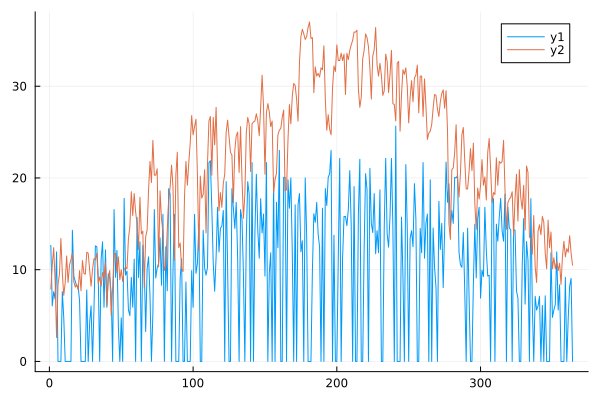

In [107]:
plot(mean(mm))
plot!(y2')

In [105]:
(mm[1]+mm[2])./2

364×1 Matrix{Float64}:
 12.65
  6.05
  7.6
  6.8
 11.939999999999998
  0.0
  0.0
  0.0
  7.6
  4.75
  0.0
  0.0
  0.0
  ⋮
 11.939999999999998
  5.6
  8.35
  0.0
  0.0
  0.0
  9.166666666666666
  0.0
  4.75
  8.2
  9.05
  0.0

In [57]:
theta = MCMCChains.group(ch, :α).value;

In [58]:
theta

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1:1:500
    :var, [Symbol("α[1]"), Symbol("α[2]"), Symbol("α[3]"), Symbol("α[4]"), Symbol("α[5]"), Symbol("α[6]"), Symbol("α[7]"), Symbol("α[8]"), Symbol("α[9]"), Symbol("α[10]")  …  Symbol("α[132]"), Symbol("α[133]"), Symbol("α[134]"), Symbol("α[135]"), Symbol("α[136]"), Symbol("α[137]"), Symbol("α[138]"), Symbol("α[139]"), Symbol("α[140]"), Symbol("α[141]")]
    :chain, 1:1
And data, a 500×141×1 Array{Float64, 3}:
[:, :, 1] =
 0.00384721   0.138381     6.53091  …  0.012841   0.0369768   3.8939
 0.00397605   0.14512      4.62883     0.015234   0.0390851   3.6667
 0.00347478   0.133364     4.31231     0.0115557  0.050154    3.54185
 0.00374816   0.154545     4.26526     0.0156055  0.0443473   3.14445
 0.00442918   0.123009     4.31496     0.0138817  0.0424622   2.85527
 0.00369082   0.082968     6.36608  …  0.0147212  0.0439795   2.33444
 0.00395547   0.0798942    6.65193     0.0167826  0.0549376   2.32066
 0.00404814   0.079

In [62]:
mm1=mean([a[i,:] for i in 1:500])

141-element Vector{Float64}:
    0.005584707838082404
    5.492616507922282
  222.31177642668285
    0.5221789738043041
    0.13493021366099137
    0.3470193209487122
   74.4744468887172
   30.078028686014466
    0.2951324911297875
 2137.5871960373925
    0.6001846871511044
   43.00651833694282
    0.0058215222380519
    ⋮
    0.3601156340487305
  115.58235041904045
    0.01852328239070038
   14.653674662381379
    6.511216120771418
    0.06127630353717711
    0.014832562170629912
    0.19286553119463573
    2.498589429759571
    2.2750972461317893
    0.021692000575450024
    4.18282270247457

In [64]:
Z=[x1 x2]

1×728 Matrix{Float64}:
 10.5  10.8  8.4  11.4  10.0  6.8  …  13.1  11.4  12.3  11.9  13.7  11.8

In [69]:
a,b=new(x1,x2,y1,kxx,mm1)

([12.65; 6.05; … ; 9.05; 0.0;;], [-0.75 0.0 … 0.0 0.0; 0.0 -0.5 … 0.0 0.0; … ; 0.0 0.0 … -0.5 0.0; 0.0 0.0 … 0.0 0.0])

In [71]:
b

364×364 Matrix{Float64}:
 -0.75   0.0   1.0    0.0        0.0  0.0  …  0.0   0.0   0.0        0.0  0.0
  0.0   -0.5   0.0    0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0  -0.75   0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0   -0.666667   0.0  0.0     1.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0       -0.8  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0  …  0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0  -0.75   0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0     0.0  -0.5   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0  …  0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0.0     0.0   0.0   0.0        0.0  0.0
  0.0    0.0   0.0    0.0        0.0  0

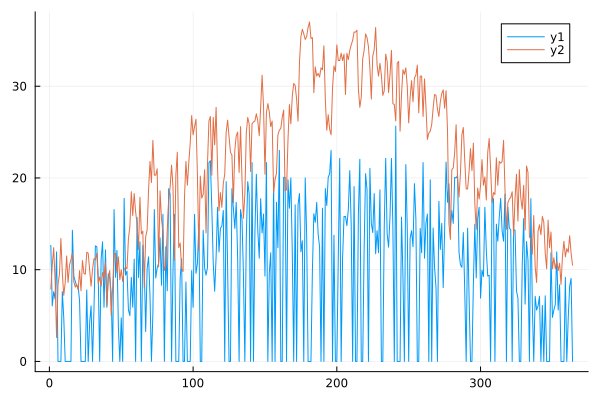

In [72]:
plot(a)
plot!(y2')

In [66]:
ktt=kxx(re(mm1),Z)

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, FunctionTransform{Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, FunctionTransform{Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1 => 10), Dense(10 => 10), Dense(10 => 1)))
x

728-element Zeros{Float64}

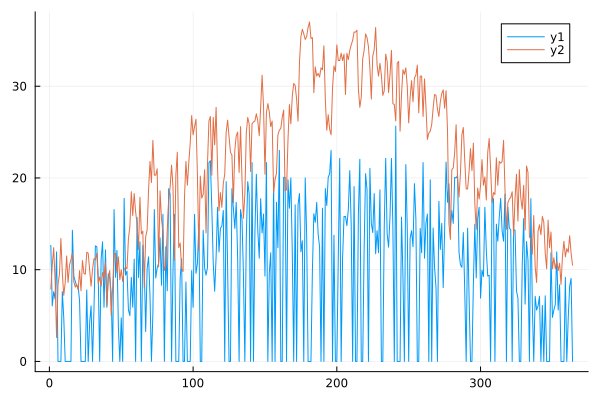

In [55]:
plot(mean(mm))
plot!(y2')

In [ ]:
HMC(0.05, 4)

In [ ]:
using StatsPlots

In [ ]:
plot